## Installs, imports and Boilerplate code

In [0]:
import warnings
warnings.filterwarnings(action='once')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  ret

In [3]:
# loading and configuring cifar10 dataset
from keras.datasets import cifar10

# x_train/test : train/test features
# y_train/test : train/test labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat',  
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")

Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

In [0]:
def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted = np.argmax(result, axis=1)
  true = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted == true)
  accuracy = float(num_correct)/result.shape[0]
  return (accuracy * 100)

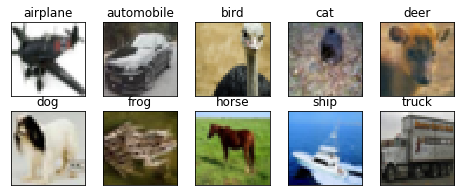

In [9]:
# Checking images, one for each class
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0]  # selecting all images of a class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0]) # selecting random no. from class idx
  im = features[img_num]  # selecting features of the image from random no.
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

In [0]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# converting class labels to one hot encoded
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## Model

In [12]:
# Define the model
model = Sequential() 
model.add(DepthwiseConv2D(3, depth_multiplier=1, use_bias=False, padding='same', input_shape=(32, 32, 3))) # 32x3x3x32 RF:3 # padding==border_mode(old version)
model.add(Convolution2D(32, 1, use_bias=False, padding='same')) # 32x3x3x32 RF:
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(DepthwiseConv2D(3, use_bias=False)) # 30x3x3x64
model.add(Convolution2D(64, 1, use_bias=False)) # 30x3x3x64
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(DepthwiseConv2D(3, use_bias=False)) # 28x3x3x128
model.add(Convolution2D(128, 1, use_bias=False))  # 28x3x3x128
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(MaxPooling2D(2)) # 14x3x3x128
model.add(Convolution2D(32, 1, use_bias=False))  # 14x3x3x32

model.add(DepthwiseConv2D(3, use_bias=False)) # 12x3x3x32 RF:3    
model.add(Convolution2D(32, 1, use_bias=False)) # 12x3x3x32 RF:
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(DepthwiseConv2D(3, use_bias=False)) # 10x3x3x64
model.add(Convolution2D(64, 1, use_bias=False)) # 10x3x3x64
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(DepthwiseConv2D(3, use_bias=False)) # 8x3x3x128
model.add(Convolution2D(128, 1, use_bias=False))  # 8x3x3x128
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(2)) # 4x3x3x128
model.add(Convolution2D(32, 1, use_bias=False))  # 4x3x3x32

model.add(DepthwiseConv2D(3, use_bias=False)) # 2x3x3x32 RF:3    
model.add(Convolution2D(32, 1, use_bias=False)) # 2x3x3x32 RF:
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(10, 1, use_bias=False)) # 2x3x3x10 RF:
model.add(GlobalAveragePooling2D()) # 1X10
model.add(Activation('softmax'))

model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_1 (Depthwis (None, 32, 32, 3)         27        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 30, 30, 32)        288 

In [0]:
# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [31]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 validation_data = (x_test, y_test),callbacks=[LearningRateScheduler(scheduler, verbose=1)], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  """


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
390/390 [==============================] - 43s 110ms/step - loss: 0.8858 - acc: 0.6919 - val_loss: 2.1933 - val_acc: 0.5349
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 39s 100ms/step - loss: 0.7248 - acc: 0.7479 - val_loss: 0.8913 - val_acc: 0.6997
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 39s 100ms/step - loss: 0.6555 - acc: 0.7725 - val_loss: 0.9393 - val_acc: 0.6800
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
390/390 [==============================] - 39s 100ms/step - loss: 0.6131 - acc: 0.7864 - val_loss: 0.8299 - val_acc: 0.7163
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0043936731.
390/390 [==============================] - 39s 101ms/step - loss: 0.5760 - acc: 0.7

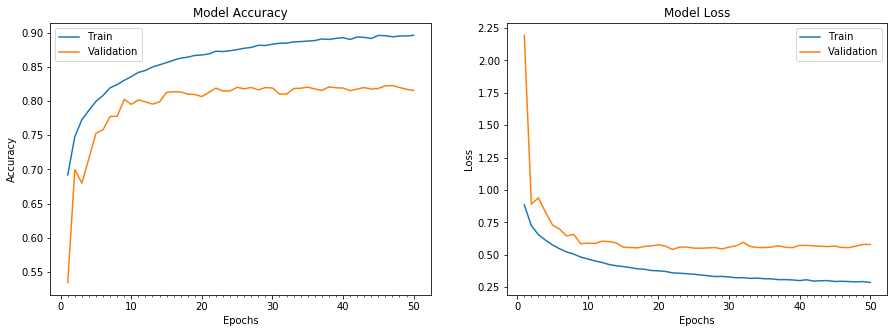

In [32]:
# plot model history
plot_model_history(model_info)

In [33]:
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

Accuracy on test data is: 81.54
